In [13]:
import numpy as np
import pandas as pd
import re
import csv
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords

from string import punctuation

from keras import backend as K
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints

seed = 1
np.random.seed(seed)
import warnings
import sys
if not sys.warnoptions:

    warnings.simplefilter("ignore")

In [14]:
train = pd.read_csv('/content/drive/MyDrive/full_train.csv')

test = pd.read_csv('/content/drive/MyDrive/full_test.csv')
print(train.shape)

train_head_seq = [text_to_word_sequence(head) for head in train['Headline']]
train_body_seq = [text_to_word_sequence(body) for body in train['articleBody']]

test_head_seq = [text_to_word_sequence(head) for head in test['Headline']]
test_body_seq = [text_to_word_sequence(body) for body in test['articleBody']]

list_words = []

for i in range(len(train_head_seq)):
    
    list_words.append(train_head_seq[i])

print(len(list_words))

for i in range(len(train_body_seq)):
    
    list_words.append(train_body_seq[i])
    
print(len(list_words))

symbols = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words= 30000, filters = symbols)

tokenizer.fit_on_texts([word for word in list_words])

print("Size of Vocabulary:", len(tokenizer.word_index))

# Now we need to maintain the len of the list
# Thus we extend the list by adding the words from the articleBody to the list with the words in the headings

train_seq = [list(i) for i in train_head_seq]

for i in range(len(train_head_seq)):
    
    train_seq[i].extend(train_body_seq[i]) 
    
    
test_seq = [list(i) for i in test_head_seq]

for i in range(len(test_head_seq)):
    
    test_seq[i].extend(test_body_seq[i])
  
print(len(train_seq))

print(len(test_seq))

# Truncating all the words more than 128 words
X_train = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in train_seq])

X_train = pad_sequences(X_train, maxlen = 128, padding = 'post', truncating = 'post')

y_train = train['Stance']
print(y_train.shape)

X_test = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in test_seq])

X_test = pad_sequences(X_test, maxlen = 128, padding = 'post', truncating = 'post')

y_test = test['Stance']
print(y_test.shape)

train_encode = LabelEncoder()

train_encode.fit(y_train)

train_encoded = train_encode.transform(y_train)

y_train = np_utils.to_categorical(train_encoded)

seed = 42

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = seed, test_size = 0.1)

test_encode = LabelEncoder()

test_encode.fit(y_test)

test_encoded = test_encode.transform(y_test)

y_test = np_utils.to_categorical(test_encoded)


print("Shape of X_train:",X_train.shape)

print("Shape of X_test:",X_test.shape)

print("Shape of y_train:",y_train.shape)

print("Shape of y_test:",y_test.shape)

(26854, 4)
26854
53708
Size of Vocabulary: 27873
26854
25413
(26854,)
(25413,)
Shape of X_train: (24168, 128)
Shape of X_test: (25413, 128)
Shape of y_train: (24168, 4)
Shape of y_test: (25413, 4)


In [15]:
import gensim

# Defining the weight matrix based on the embedding 

word_embeddings = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/wiki-news-300d-1M.vec')

weight_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 300)) 

for word, i in tokenizer.word_index.items(): 
    
    try:
        word_embeddings_vector = word_embeddings[word]
        
    except KeyError:
        
        word_embeddings_vector = None

    if word_embeddings_vector is not None:
        
        weight_matrix[i] = word_embeddings_vector
                
del word_embeddings


import keras

from keras.layers import Input, Dense, Embedding, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv1D

from keras.layers.convolutional import MaxPooling1D

keras.backend.clear_session()

model = Sequential()

model.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300, weights = [weight_matrix], trainable = True, input_length = 128))

model.add(Conv1D(256, 3, padding='same', activation='relu'))

model.add(MaxPooling1D())

model.add(Conv1D(128, 3, padding='same', activation='relu'))

model.add(MaxPooling1D())

model.add(Conv1D(64, 3, padding='same', activation='relu'))

model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(rate = 0.25))

model.add(Dense(4,activation ='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.save('models/CNN_final.h5')

In [16]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
189/189 [==============================] - 149s 782ms/step - loss: 0.8941 - accuracy: 0.6113 - val_loss: 0.6827 - val_accuracy: 0.7223
Epoch 2/20
189/189 [==============================] - 147s 779ms/step - loss: 0.4959 - accuracy: 0.8046 - val_loss: 0.4126 - val_accuracy: 0.8466
Epoch 3/20
189/189 [==============================] - 147s 780ms/step - loss: 0.3230 - accuracy: 0.8778 - val_loss: 0.3556 - val_accuracy: 0.8589
Epoch 4/20
189/189 [==============================] - 147s 779ms/step - loss: 0.2280 - accuracy: 0.9122 - val_loss: 0.3266 - val_accuracy: 0.8842
Epoch 5/20
189/189 [==============================] - 148s 781ms/step - loss: 0.1875 - accuracy: 0.9285 - val_loss: 0.3210 - val_accuracy: 0.8879
Epoch 6/20
189/189 [==============================] - 148s 779ms/step - loss: 0.1512 - accuracy: 0.9429 - val_loss: 0.3320 - val_accuracy: 0.8987
Epoch 7/20
189/189 [==============================] - 146s 774ms/step - loss: 0.1295 - accuracy: 0.9506 - val_loss: 0.3163 -

In [17]:
import pickle

with open('FNC_CNN_Fasttext.pickle', 'wb') as f:
    
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://37cb64e8-f06e-4249-a787-5615a80a52b7/assets


In [18]:
with open('FNC_CNN_Fasttext.pickle', 'rb') as f:
    
    history = pickle.load(f)

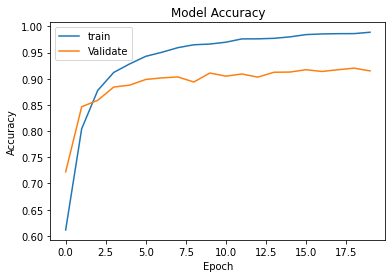

In [19]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['train', 'Validate'])

plt.show()

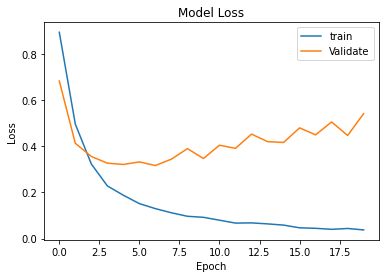

In [20]:
# Loss Plot

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.legend(['train', 'Validate'])

plt.show()

In [21]:

# Predict the stances for the test data

pred = model.predict(X_test)

predicted_labels = [np.argmax(p, axis = -1) for p in pred]

True_labels = [np.argmax(p, axis = -1) for p in y_test]

In [22]:
# Convert the stances to the text stances

for i in range(len(predicted_labels)):

    if predicted_labels[i] == 0: predicted_labels[i] = "agree"

    if predicted_labels[i] == 1: predicted_labels[i] = "disagree"

    if predicted_labels[i] == 2: predicted_labels[i] = "discuss"

    if predicted_labels[i] == 3: predicted_labels[i] = "unrelated"

for i in range(len(True_labels)):

    if True_labels[i] == 0: True_labels[i] = "agree"

    if True_labels[i] == 1: True_labels[i] = "disagree"

    if True_labels[i] == 2: True_labels[i] = "discuss"

    if True_labels[i] == 3: True_labels[i] = "unrelated"

In [26]:
test_df = pd.read_csv('/content/drive/MyDrive/competition_test_stances.csv')

In [27]:
# Replacing the original stance labels with the predicted labels

pred_stance = predicted_labels

bodyid = []

headline = []

for i in range(len(test_df.Stance)):

    bodyid.append(test_df['Body ID'][i])

    headline.append(test_df['Headline'][i])

In [28]:
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})

In [29]:
df_submit.to_csv('answer_CNN_Fasttext_Final.csv', index = False, encoding = 'utf-8')

In [30]:
score, acc = model.evaluate(X_test, y_test, batch_size = 128)

199/199 [==============================] - 34s 170ms/step - loss: 2.5028 - accuracy: 0.6372


In [31]:
print("Test Accuracy:", acc)

Test Accuracy: 0.6372328996658325
